## Time Series Prediction With Deep Learning in Keras

International airline passengers prediction problem.
	
    This is a problem where given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. 
    The data ranges from January 1949 to December 1960 or 12 years, with 144 observations.

Load required modules

In [1]:
import numpy
import pandas
import math
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using Theano backend.


#### Load this dataset using the Pandas library. 


We are not interested in the date, given that each observation is separated by the same interval of one month. 
    
    Exclude the first column.
The downloaded dataset has footer information. 
    
    That can be exclude with the skipfooter argument to pandas.read_csv() set to 3 for the 3 footer lines.m

In [2]:
dataframe = pandas.read_csv('international-airline-passengers.csv', 
                          usecols=[1], engine='python', skipfooter=3)

Extract the NumPy array from the dataframe and convert the integer values to floating point values.

In [3]:
dataset = dataframe.values
dataset = dataset.astype('float32')

#### Plot the dataset

<IPython.core.display.Javascript object>


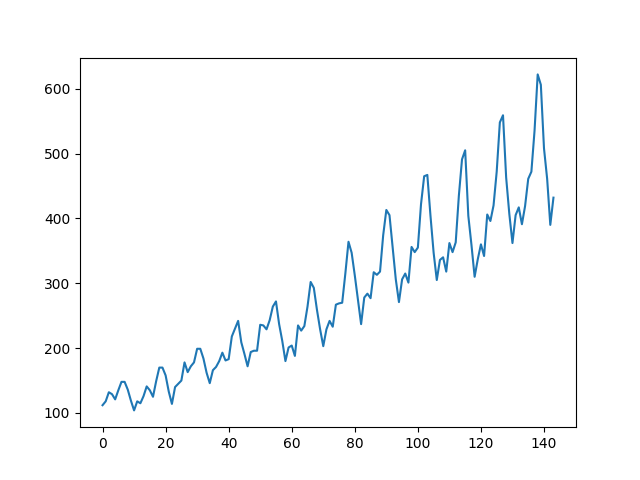

In [4]:
%matplotlib notebook
plt.plot(dataset)
plt.show()

### Multilayer Perceptron Regression

Phrase the time series prediction problem as a regression problem. i.e. given the number of passengers this month, what is the number of passengers next month.

Fix random seed for reproducibility

In [5]:
numpy.random.seed(123)

Divide the data into train and test

    Note: With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets.


In [6]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

(96, 48)



Write a simple function to convert our single column of data into a two-column dataset. 
The first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

The function takes two arguments

    The dataset which is a NumPy array and 
    The look_back which is the number of previous time steps to use as input variables to predict the next time period (defaulted is 1)

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

In [7]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

Using above function, and prepare the train and test datasets.

In [8]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

Build the Multilayer Perceptron model with 1 input, 1 hidden layer with 8 neurons and an output layer.`

In [9]:
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=2)

Epoch 1/200
0s - loss: 47623.2774
Epoch 2/200
0s - loss: 36741.6585
Epoch 3/200
0s - loss: 27064.2743
Epoch 4/200
0s - loss: 18645.6054
Epoch 5/200
0s - loss: 11839.3148
Epoch 6/200
0s - loss: 6716.2721
Epoch 7/200
0s - loss: 3459.5725
Epoch 8/200
0s - loss: 1728.9364
Epoch 9/200
0s - loss: 930.7378
Epoch 10/200
0s - loss: 650.7179
Epoch 11/200
0s - loss: 565.9476
Epoch 12/200
0s - loss: 545.3670
Epoch 13/200
0s - loss: 540.0184
Epoch 14/200
0s - loss: 537.5020
Epoch 15/200
0s - loss: 540.1864
Epoch 16/200
0s - loss: 536.5791
Epoch 17/200
0s - loss: 540.7713
Epoch 18/200
0s - loss: 538.9462
Epoch 19/200
0s - loss: 540.1053
Epoch 20/200
0s - loss: 537.9382
Epoch 21/200
0s - loss: 541.4455
Epoch 22/200
0s - loss: 539.4083
Epoch 23/200
0s - loss: 536.5803
Epoch 24/200
0s - loss: 536.9157
Epoch 25/200
0s - loss: 544.2774
Epoch 26/200
0s - loss: 544.4138
Epoch 27/200
0s - loss: 544.1783
Epoch 28/200
0s - loss: 543.9329
Epoch 29/200
0s - loss: 538.3163
Epoch 30/200
0s - loss: 542.7550
Epoch 

Estimate the performance of the model on the train and test datasets

In [10]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 530.50 MSE (23.03 RMSE)
Test Score: 2351.06 MSE (48.49 RMSE)


On both train and test, predictions using the built model

In [11]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#### Plot the data

Because of how the dataset was prepared, we must shift the predictions so that they aline on the x-axis with the original dataset. 

In [12]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

<IPython.core.display.Javascript object>


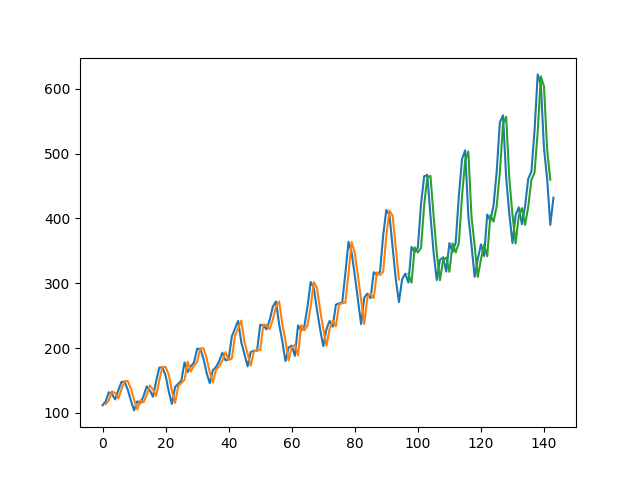

In [13]:
%matplotlib notebook
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


### Multilayer Perceptron Using the Window Method

Multiple recent time steps can be used to make the prediction for the next time step.

This is called the window method, and the size of the window is a parameter that can be tuned for each problem.

E.g. time (t-2), time (t-1), and time (t) can be used predict time (t+1).

In [14]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

Build the Multilayer Perceptron model with 3 input, 1 hidden layer with 8 neurons and an output layer.`

In [15]:
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=2)

Epoch 1/200
0s - loss: 2624.0709
Epoch 2/200
0s - loss: 1155.4089
Epoch 3/200
0s - loss: 1020.6774
Epoch 4/200
0s - loss: 950.9186
Epoch 5/200
0s - loss: 878.2024
Epoch 6/200
0s - loss: 806.6989
Epoch 7/200
0s - loss: 762.3099
Epoch 8/200
0s - loss: 733.2548
Epoch 9/200
0s - loss: 715.2589
Epoch 10/200
0s - loss: 700.6225
Epoch 11/200
0s - loss: 693.2350
Epoch 12/200
0s - loss: 694.2618
Epoch 13/200
0s - loss: 683.3731
Epoch 14/200
0s - loss: 687.9060
Epoch 15/200
0s - loss: 668.0593
Epoch 16/200
0s - loss: 675.8889
Epoch 17/200
0s - loss: 661.6029
Epoch 18/200
0s - loss: 667.0624
Epoch 19/200
0s - loss: 659.5543
Epoch 20/200
0s - loss: 657.1568
Epoch 21/200
0s - loss: 644.2151
Epoch 22/200
0s - loss: 642.5143
Epoch 23/200
0s - loss: 632.0900
Epoch 24/200
0s - loss: 634.8873
Epoch 25/200
0s - loss: 625.2374
Epoch 26/200
0s - loss: 618.1720
Epoch 27/200
0s - loss: 623.9321
Epoch 28/200
0s - loss: 618.0005
Epoch 29/200
0s - loss: 624.3990
Epoch 30/200
0s - loss: 605.5913
Epoch 31/200
0s 

Estimate the performance of the model on the train and test datasets

In [16]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 517.74 MSE (22.75 RMSE)
Test Score: 2301.45 MSE (47.97 RMSE)


On both train and test, predictions using the built model

In [17]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#### Plot the data

Because of how the dataset was prepared, we must shift the predictions so that they aline on the x-axis with the original dataset. 

In [18]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

<IPython.core.display.Javascript object>


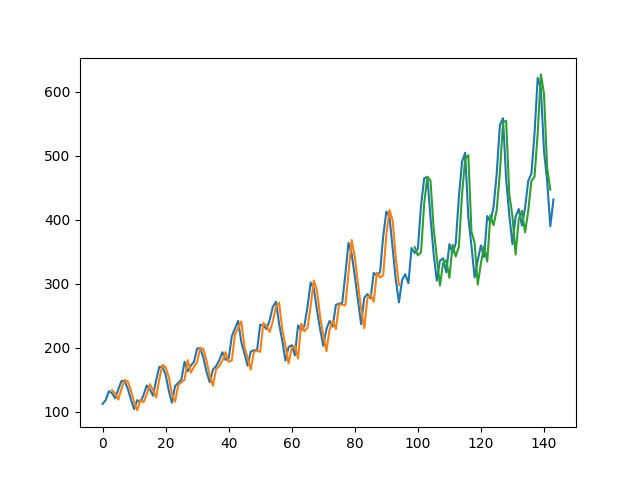

In [19]:
%matplotlib notebook
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


### Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras

Unlike regression predictive modeling, time series also adds the complexity of a sequence dependence among the input variables.

A powerful type of neural network designed to handle sequence dependence is called recurrent neural networks. 

    LSTM network is a type of recurrent neural network used in deep learning 

###### LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. 

    We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [20]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

The code below calculates the index of the split point and separates the data into the train and test

In [21]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

(96, 48)


Prepare the train and test datasets using create_dataset function

In [22]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form 

    [samples, time steps, features].

Currently, our data is in the form: [samples, features]

We are framing the problem as one time step for each sample. 

Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [23]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

###### Design and fit our LSTM network for this problem.

The network has 

    A visible layer with 1 input, 
    A hidden layer with 4 LSTM blocks or neurons, and 
    An output layer that makes a single value prediction. 
    The default sigmoid activation function is used for the LSTM blocks. 
    The network is trained for 100 epochs and a batch size of 1 is used.

In [24]:
# create the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))

# Compile the LSTM network
model.compile(loss='mean_squared_error', optimizer='adam')

# fit the LSTM network
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
0s - loss: 0.0190
Epoch 2/100
0s - loss: 0.0087
Epoch 3/100
0s - loss: 0.0074
Epoch 4/100
0s - loss: 0.0067
Epoch 5/100
0s - loss: 0.0060
Epoch 6/100
0s - loss: 0.0055
Epoch 7/100
0s - loss: 0.0048
Epoch 8/100
0s - loss: 0.0043
Epoch 9/100
0s - loss: 0.0038
Epoch 10/100
0s - loss: 0.0034
Epoch 11/100
0s - loss: 0.0031
Epoch 12/100
0s - loss: 0.0028
Epoch 13/100
0s - loss: 0.0026
Epoch 14/100
0s - loss: 0.0024
Epoch 15/100
0s - loss: 0.0023
Epoch 16/100
0s - loss: 0.0022
Epoch 17/100
0s - loss: 0.0021
Epoch 18/100
0s - loss: 0.0021
Epoch 19/100
0s - loss: 0.0020
Epoch 20/100
0s - loss: 0.0020
Epoch 21/100
0s - loss: 0.0020
Epoch 22/100
0s - loss: 0.0020
Epoch 23/100
0s - loss: 0.0020
Epoch 24/100
0s - loss: 0.0020
Epoch 25/100
0s - loss: 0.0020
Epoch 26/100
0s - loss: 0.0020
Epoch 27/100
0s - loss: 0.0020
Epoch 28/100
0s - loss: 0.0020
Epoch 29/100
0s - loss: 0.0020
Epoch 30/100
0s - loss: 0.0020
Epoch 31/100
0s - loss: 0.0020
Epoch 32/100
0s - loss: 0.0020
Epoch 33/100
0s -

Estimate the performance of the model on the train and test datasets. 

In [25]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data 

In [26]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [27]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.74 RMSE
Test Score: 50.22 RMSE


##### Prepare and plot the data

<IPython.core.display.Javascript object>


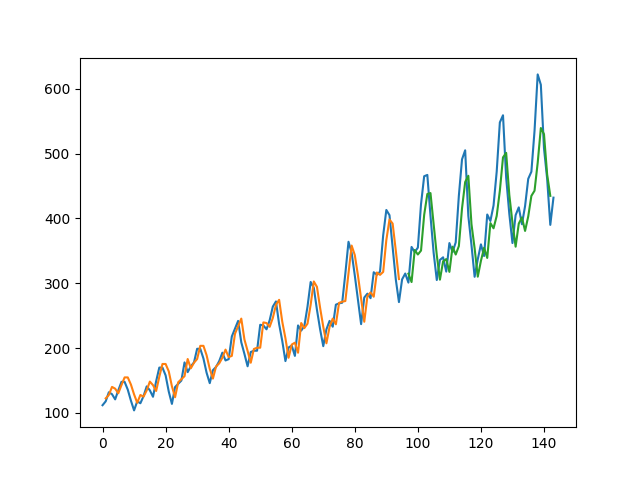

In [28]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
%matplotlib notebook
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### LSTM for Regression Using the Window Method

We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step.

This is called a window, and the size of the window is a parameter that can be tuned for each problem.

    When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.

In [29]:
# reshape into X=t-2, t-1, t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form 

    [samples, time steps, features].

In [30]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
# create the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))

# compile the LSTM network
model.compile(loss='mean_squared_error', optimizer='adam')

# fit the LSTM network
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
0s - loss: 0.0371
Epoch 2/100
0s - loss: 0.0136
Epoch 3/100
0s - loss: 0.0098
Epoch 4/100
0s - loss: 0.0081
Epoch 5/100
0s - loss: 0.0068
Epoch 6/100
0s - loss: 0.0056
Epoch 7/100
0s - loss: 0.0047
Epoch 8/100
0s - loss: 0.0040
Epoch 9/100
0s - loss: 0.0036
Epoch 10/100
0s - loss: 0.0032
Epoch 11/100
0s - loss: 0.0030
Epoch 12/100
0s - loss: 0.0029
Epoch 13/100
0s - loss: 0.0028
Epoch 14/100
0s - loss: 0.0028
Epoch 15/100
0s - loss: 0.0027
Epoch 16/100
0s - loss: 0.0027
Epoch 17/100
0s - loss: 0.0028
Epoch 18/100
0s - loss: 0.0026
Epoch 19/100
0s - loss: 0.0027
Epoch 20/100
0s - loss: 0.0026
Epoch 21/100
0s - loss: 0.0026
Epoch 22/100
0s - loss: 0.0026
Epoch 23/100
0s - loss: 0.0026
Epoch 24/100
0s - loss: 0.0026
Epoch 25/100
0s - loss: 0.0025
Epoch 26/100
0s - loss: 0.0025
Epoch 27/100
0s - loss: 0.0025
Epoch 28/100
0s - loss: 0.0025
Epoch 29/100
0s - loss: 0.0024
Epoch 30/100
0s - loss: 0.0025
Epoch 31/100
0s - loss: 0.0025
Epoch 32/100
0s - loss: 0.0024
Epoch 33/100
0s -

Estimate the performance of the model on the train and test datasets. 

In [32]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data 

In [33]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])


testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [34]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.73 RMSE
Test Score: 61.90 RMSE


##### Prepare and plot the data

<IPython.core.display.Javascript object>


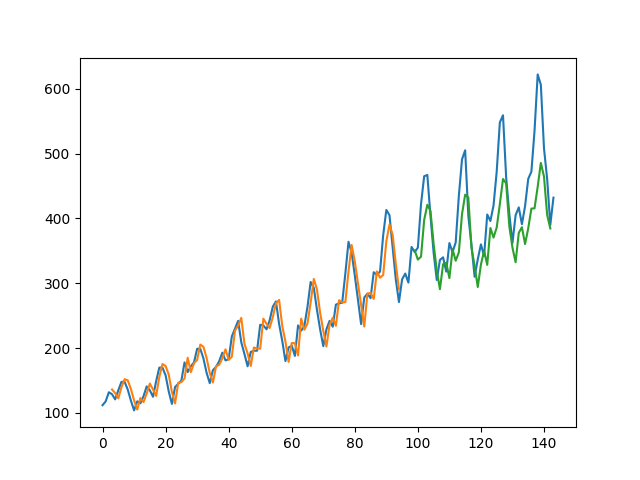

In [35]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
%matplotlib notebook
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### LSTM for Regression with Time Steps

Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem.

In [36]:
# reshape into X=t-2, t-1, t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form 

    [samples, time steps, features].

In [37]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [38]:
# create the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=1))
model.add(Dense(1))

# compile the LSTM network
model.compile(loss='mean_squared_error', optimizer='adam')

# fit the LSTM network
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
0s - loss: 0.0263
Epoch 2/100
0s - loss: 0.0100
Epoch 3/100
0s - loss: 0.0081
Epoch 4/100
0s - loss: 0.0069
Epoch 5/100
0s - loss: 0.0058
Epoch 6/100
0s - loss: 0.0051
Epoch 7/100
0s - loss: 0.0046
Epoch 8/100
0s - loss: 0.0043
Epoch 9/100
0s - loss: 0.0041
Epoch 10/100
0s - loss: 0.0042
Epoch 11/100
0s - loss: 0.0040
Epoch 12/100
0s - loss: 0.0039
Epoch 13/100
0s - loss: 0.0039
Epoch 14/100
0s - loss: 0.0038
Epoch 15/100
0s - loss: 0.0038
Epoch 16/100
0s - loss: 0.0038
Epoch 17/100
0s - loss: 0.0039
Epoch 18/100
0s - loss: 0.0038
Epoch 19/100
0s - loss: 0.0037
Epoch 20/100
0s - loss: 0.0038
Epoch 21/100
0s - loss: 0.0038
Epoch 22/100
0s - loss: 0.0037
Epoch 23/100
0s - loss: 0.0036
Epoch 24/100
0s - loss: 0.0036
Epoch 25/100
0s - loss: 0.0037
Epoch 26/100
0s - loss: 0.0036
Epoch 27/100
0s - loss: 0.0036
Epoch 28/100
0s - loss: 0.0035
Epoch 29/100
0s - loss: 0.0036
Epoch 30/100
0s - loss: 0.0035
Epoch 31/100
0s - loss: 0.0036
Epoch 32/100
0s - loss: 0.0035
Epoch 33/100
0s -

Estimate the performance of the model on the train and test datasets. 

In [39]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data 

In [40]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [41]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 25.24 RMSE
Test Score: 63.62 RMSE


##### Prepare and plot the data

<IPython.core.display.Javascript object>


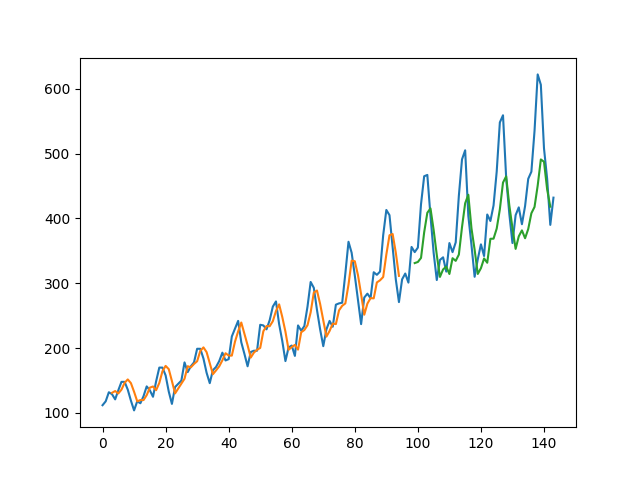

In [42]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
%matplotlib notebook
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()